<a href="https://colab.research.google.com/github/samriddhi-m1227/ML-DL/blob/main/ML_DL_Project_SamriddhiM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Olympic Medal Counts
#### By: Samriddhi Matharu

Dataset Description

The dataset (check folder for Data) includes:

- iso: Country ISO code
- ioc: International Olympic Committee code
- name: Country name
- continent: Continent of the country
- population: Population of the country
- gdp: Gross Domestic Product (GDP) of the country
- olympics_index: An index indicating the country's overall performance in the Olympics
- sports_index: An index indicating the country's sports infrastructure and support
- olympicsIndex: A calculated index related to Olympic performance
- sportsIndex: A calculated index related to sports
- total: Total number of medals won
- gold: Number of gold medals won
- silver: Number of silver medals won
- bronze: Number of bronze medals won

In [2]:
#Load the dataset
import pandas as pd

data= pd.read_csv("gni-olympics.csv")
data.head()

,iso,ioc,name,continent,population,gdp,olympics_index,sports_index,olympicsIndex,sportsIndex,total,gold,silver,bronze
0,ARG,ARG,Argentina,South America,45376763,383066977654,19.597142,9.324537,19.597142,9.324537,3,0,1,2
1,ARM,ARM,Armenia,Asia,2963234,12645459214,19.681457,13.497324,19.681457,13.497324,4,0,2,2
2,AUS,AUS,Australia,Oceania,25687041,1330900925057,31.170099,11.073845,31.170099,11.073845,46,17,7,22
3,AUT,AUT,Austria,Europe,8917205,428965397959,12.212139,15.923033,12.212139,15.923033,7,1,1,5
4,AZE,AZE,Azerbaijan,Europe,10110116,42607176471,18.213838,13.103344,18.213838,13.103344,7,0,3,4


I noticed that 'olympics_index' and 'sports_index' are the same in values as 'olympicsIndex' and 'sportsIndex'. Even the csv files shows the exact same values for those two sets of columns. I will be dropping two of them, before proceeding ( 'olympicsIndex' and 'sportsIndex' ).

In [3]:
# Drop the duplicate columns
data = data.drop(columns=['olympicsIndex', 'sportsIndex'])

# Verify if the columns are dropped again.
data.head()


,iso,ioc,name,continent,population,gdp,olympics_index,sports_index,total,gold,silver,bronze
0,ARG,ARG,Argentina,South America,45376763,383066977654,19.597142,9.324537,3,0,1,2
1,ARM,ARM,Armenia,Asia,2963234,12645459214,19.681457,13.497324,4,0,2,2
2,AUS,AUS,Australia,Oceania,25687041,1330900925057,31.170099,11.073845,46,17,7,22
3,AUT,AUT,Austria,Europe,8917205,428965397959,12.212139,15.923033,7,1,1,5
4,AZE,AZE,Azerbaijan,Europe,10110116,42607176471,18.213838,13.103344,7,0,3,4


In [4]:
#Import all the libraries

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

## 1. Data Preprocessing

### Data Cleaning

In [5]:
#Check Missing Values

print(data.isnull().sum())

#we have 5 missing values for the continent along with 2 missing 'sports_index' and 'olympics_index'

iso               0
ioc               0
name              0
continent         5
population        0
gdp               0
olympics_index    2
sports_index      2
total             0
gold              0
silver            0
bronze            0
dtype: int64


In [6]:
missing_continent = data[data['continent'].isnull()]
print(missing_continent[['name', 'iso', 'ioc']])

               name  iso  ioc
17    Côte d'Ivoire  CIV  CIV
57          Moldova  MDA  MDA
59  North Macedonia  MKD  MKD
80            Syria  SYR  SYR
91           Kosovo  XKX  KOS


So we can map to the continents using 'iso':
- Côte d'Ivoire (CIV): Africa
- Moldova (MDA): Europe
- North Macedonia (MKD): Europe
- Syria (SYR): Asia
- Kosovo (XKX): Europe

In [7]:
# Mapping country names to continents for missing values
country_to_continent = {
    "Côte d'Ivoire": 'Africa',
    'Moldova': 'Europe',
    'North Macedonia': 'Europe',
    'Syria': 'Asia',
    'Kosovo': 'Europe'
}

data['continent'] = data.apply(lambda row: country_to_continent.get(row['name'], row['continent']), axis=1)

# Verify that no missing 'continent' values remain
print(data['continent'].isnull().sum())

0


So now for the 2 missing 'sports_index' and 'olympics_index' , we can fill the missing values, considering the country and its continent

In [8]:
# Calculate the mean sports_index and olympics_index for each continent
continent_means = data.groupby('continent')[['sports_index', 'olympics_index']].mean()

def fill_missing_index(row):
    if pd.isnull(row['sports_index']):
        row['sports_index'] = continent_means.loc[row['continent'], 'sports_index']
    if pd.isnull(row['olympics_index']):
        row['olympics_index'] = continent_means.loc[row['continent'], 'olympics_index']
    return row

# Apply the function to fill missing values
data = data.apply(fill_missing_index, axis=1)

# Verify that no missing values remain for these columns
print(data[['sports_index', 'olympics_index']].isnull().sum())

sports_index      0
olympics_index    0
dtype: int64


In [9]:
#Just for extra measures we can check again to see the total missing values, if any:

print(data.isnull().sum())

#there are 0 so we are good to go

iso               0
ioc               0
name              0
continent         0
population        0
gdp               0
olympics_index    0
sports_index      0
total             0
gold              0
silver            0
bronze            0
dtype: int64


In [10]:
# Identify duplicate rows, if any
duplicates = data[data.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [iso, ioc, name, continent, population, gdp, olympics_index, sports_index, total, gold, silver, bronze]
Index: []


There are no duplicates in the dataset

### Feature Engineering

In [11]:
#This is can show how economic strength per population will play an effect on Olympic peroformance
data['gdp_per_capita'] = data['gdp'] / data['population']

#This can show how sport infrastructure and support can impact overall Olympic performnace
data['sports_olympics_interaction'] = data['sports_index'] * data['olympics_index']


In [12]:
# Normalize numerical features
numerical_features = ['population', 'gdp', 'olympics_index', 'sports_index']

scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [13]:
#We are doing One hot encoding on the 'continent' column
data= pd.get_dummies(data, columns=['continent'])

print(data.head())

   iso  ioc        name  population       gdp  olympics_index  sports_index  \
0  ARG  ARG   Argentina   -0.102696 -0.179988       -0.087715     -0.798305   
1  ARM  ARM     Armenia   -0.309957 -0.317802       -0.080930     -0.323474   
2  AUS  AUS   Australia   -0.198914  0.172653        0.843628     -0.599247   
3  AUT  AUT     Austria   -0.280862 -0.162911       -0.682030     -0.047447   
4  AZE  AZE  Azerbaijan   -0.275033 -0.306655       -0.199038     -0.368306   

   total  gold  silver  bronze  gdp_per_capita  sports_olympics_interaction  \
0      3     0       1       2     8441.919439                   182.734275   
1      4     0       2       2     4267.452120                   265.647010   
2     46    17       7      22    51812.154037                   345.172845   
3      7     1       1       5    48105.364625                   194.454291   
4      7     0       3       4     4214.311336                   238.662184   

   continent_Africa  continent_Asia  continent_Eur

In [14]:
#Replacing 'True' with 1 and 'Flase' with 0.
data = data.replace({True: 1, False: 0})

In [15]:
data.head()

,iso,ioc,name,population,gdp,olympics_index,sports_index,total,gold,silver,bronze,gdp_per_capita,sports_olympics_interaction,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America
0,ARG,ARG,Argentina,-0.102696,-0.179988,-0.087715,-0.798305,3,0,1,2,8441.919439,182.734275,0,0,0,0,0,1
1,ARM,ARM,Armenia,-0.309957,-0.317802,-0.080930,-0.323474,4,0,2,2,4267.452120,265.647010,0,1,0,0,0,0
2,AUS,AUS,Australia,-0.198914,0.172653,0.843628,-0.599247,46,17,7,22,51812.154037,345.172845,0,0,0,0,1,0
3,AUT,AUT,Austria,-0.280862,-0.162911,-0.682030,-0.047447,7,1,1,5,48105.364625,194.454291,0,0,1,0,0,0
4,AZE,AZE,Azerbaijan,-0.275033,-0.306655,-0.199038,-0.368306,7,0,3,4,4214.311336,238.662184,0,0,1,0,0,0


### Data Splitting

In [37]:
# Define features (X) and target (y)
X = data.drop(columns=['total', 'iso', 'ioc', 'name'])   # Drop non-numeric and target columns
y = data['total']  # Target variable

In [38]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Exploratory Data Analysis (EDA)

### Descriptive Statistics

In [39]:
#Basic statistics for numerical features
print(data.describe())

         population           gdp  olympics_index  sports_index       total  \
count  9.300000e+01  9.300000e+01    9.300000e+01  9.300000e+01   93.000000   
mean   1.477313e-17 -3.074005e-17    1.384794e-16 -2.817340e-16   11.612903   
std    1.005420e+00  1.005420e+00    1.005420e+00  1.005420e+00   19.091332   
min   -3.242719e-01 -3.225072e-01   -1.584336e+00 -1.017704e+00    1.000000   
25%   -3.000301e-01 -3.062496e-01   -6.112881e-01 -6.053800e-01    2.000000   
50%   -2.690883e-01 -2.593201e-01   -1.528566e-01 -2.670568e-01    4.000000   
75%   -9.304614e-02 -1.307783e-01    4.305687e-01  3.009549e-01   11.000000   
max    6.527224e+00  7.466931e+00    6.382772e+00  6.359551e+00  113.000000   

            gold     silver     bronze  gdp_per_capita  \
count  93.000000  93.000000  93.000000       93.000000   
mean    3.655914   3.634409   4.322581    21087.175185   
std     7.022471   6.626339   6.210372    22614.122869   
min     0.000000   0.000000   0.000000        0.000000  

### Visualization

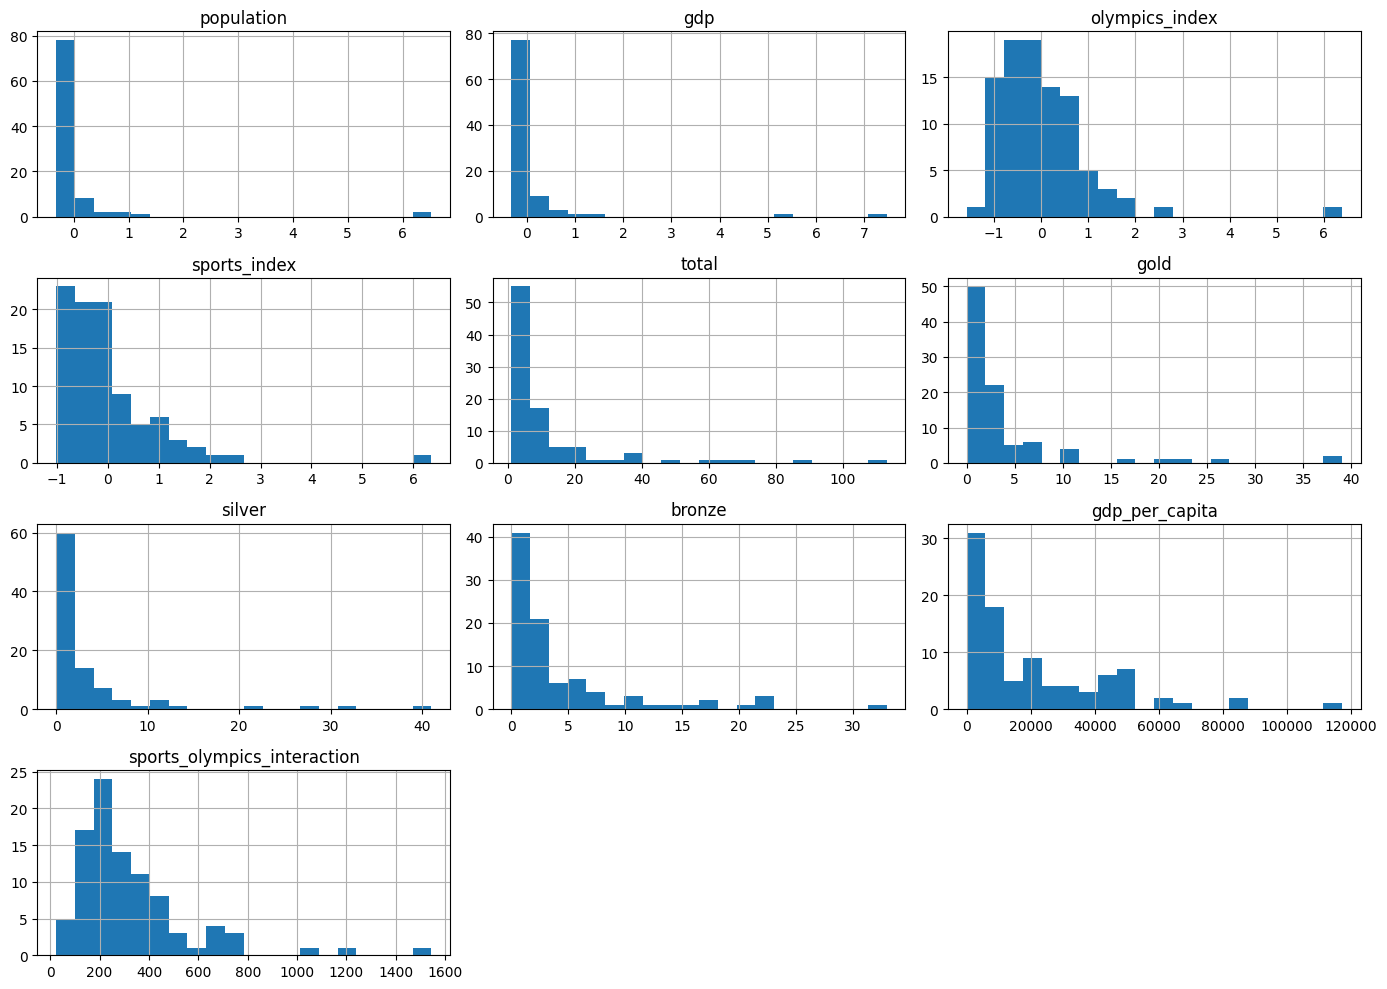

In [40]:
# Histograms
data[['population', 'gdp', 'olympics_index', 'sports_index', 'total', 'gold', 'silver', 'bronze', 'gdp_per_capita', 'sports_olympics_interaction']].hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

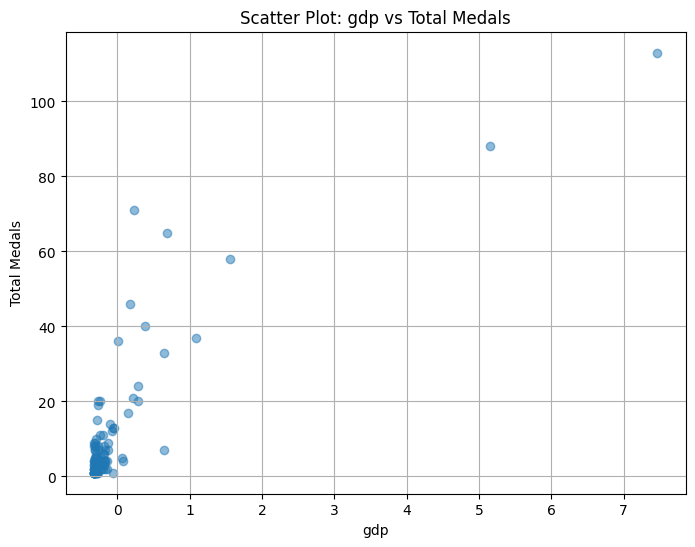

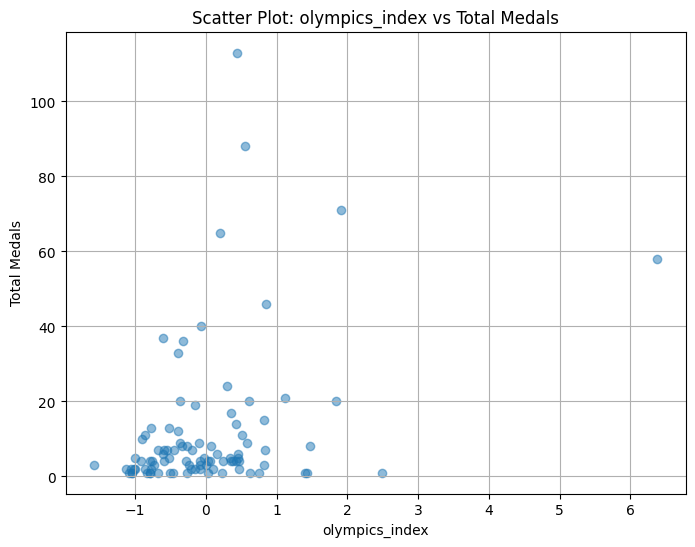

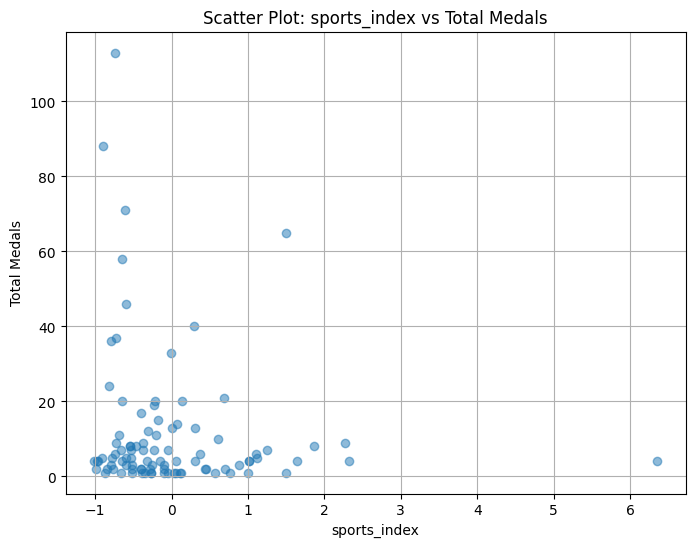

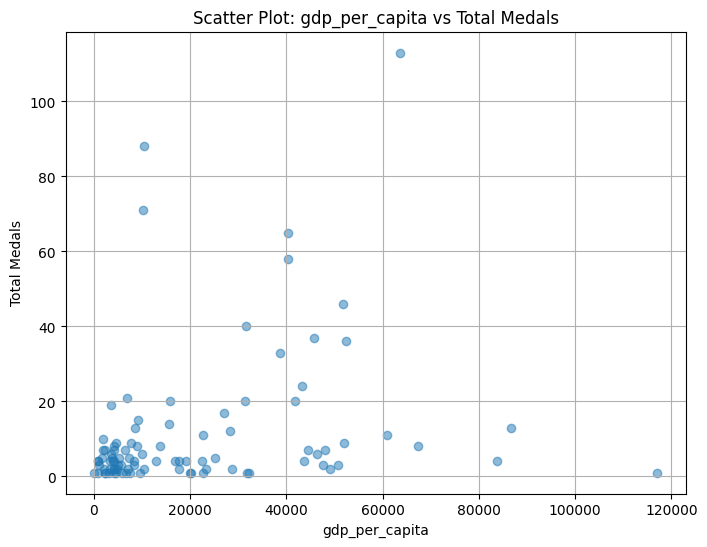

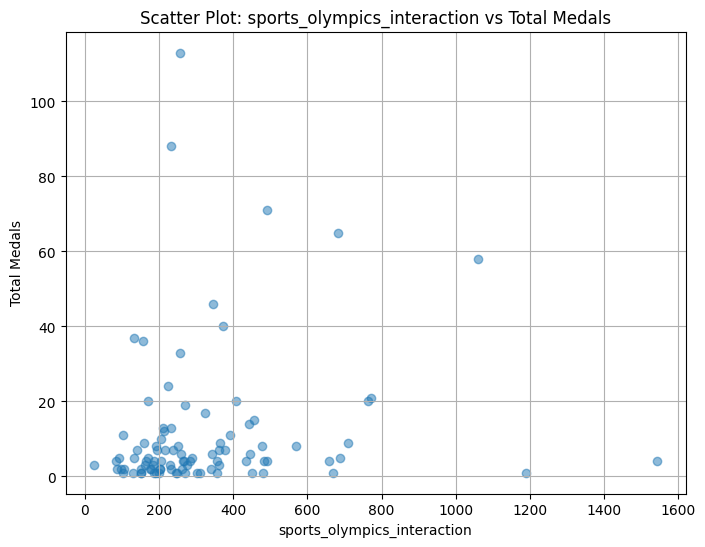

In [41]:
# Scatter plots
features = ['gdp', 'olympics_index', 'sports_index', 'gdp_per_capita', 'sports_olympics_interaction']
for feature in features:
    plt.figure(figsize=(8, 6))
    plt.scatter(data[feature], data['total'], alpha=0.5)
    plt.title(f'Scatter Plot: {feature} vs Total Medals')
    plt.xlabel(feature)
    plt.ylabel('Total Medals')
    plt.grid(True)
    plt.show()

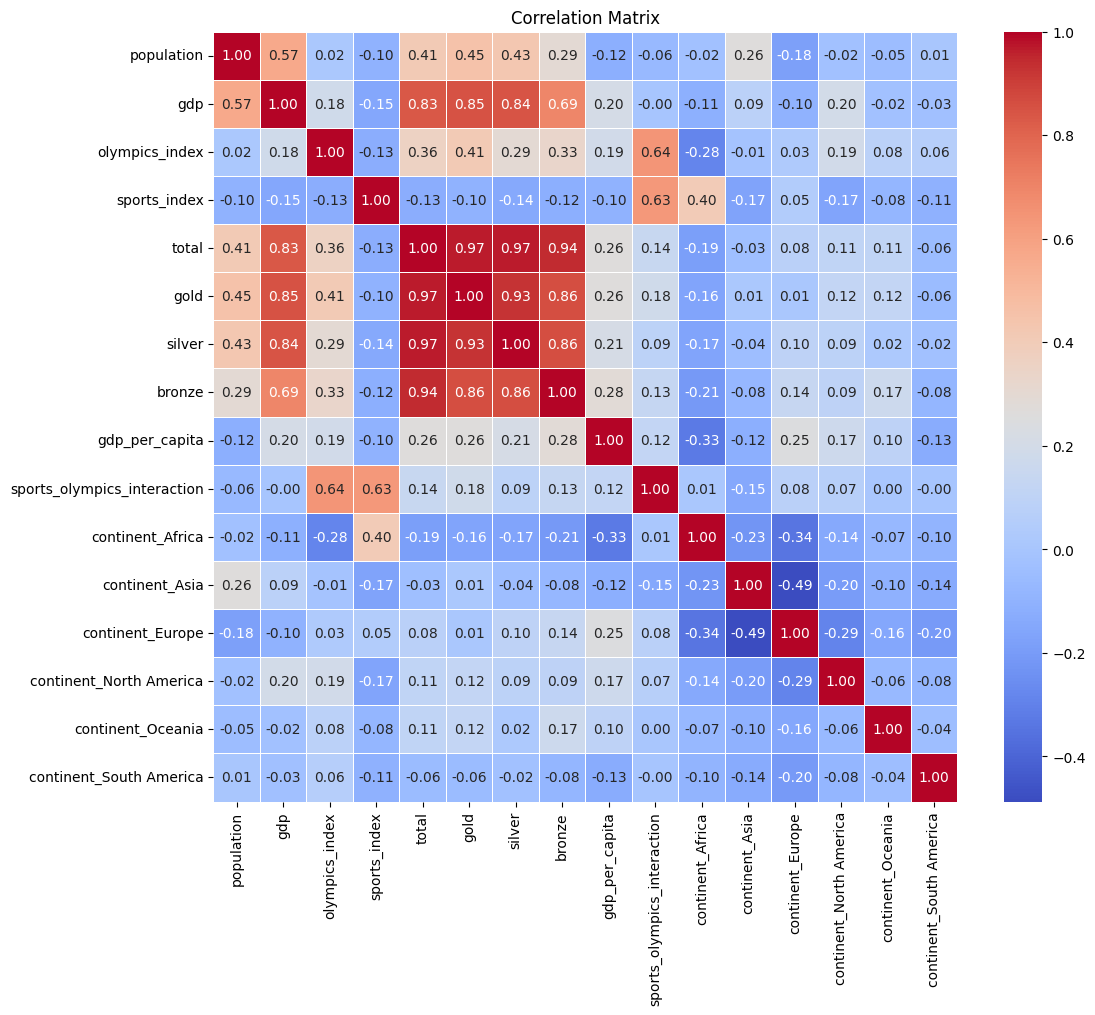

In [42]:
# Correlation matrix
numeric_data = data.select_dtypes(include=[float, int])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [43]:
total_corr = correlation_matrix['total'].sort_values(ascending=False)
print(total_corr)

total                          1.000000
gold                           0.970840
silver                         0.969439
bronze                         0.941941
gdp                            0.831683
population                     0.410505
olympics_index                 0.359389
gdp_per_capita                 0.263079
sports_olympics_interaction    0.140971
continent_North America        0.107615
continent_Oceania              0.106282
continent_Europe               0.080442
continent_Asia                -0.034252
continent_South America       -0.055396
sports_index                  -0.126646
continent_Africa              -0.186113
Name: total, dtype: float64


### Feature Analysis

Gold, Silver, and Bronze will naturally have a high correlation with total because they directly contribute to the total medal count, so I will be excluding them.
- GDP (0.83): This remains the strongest independent predictor of total medals.
- Population (0.41): A moderate predictor, suggesting that more populous countries have a higher likelihood of winning more medals.
- Olympics Index (0.36): This still contributes as a moderate predictor of total medals.
- GDP per Capita (0.26): While less strong, it might add some value, especially in combination with other features.
- Sports Olympics Interaction (0.14): A weak predictor on its own..

## 3. Machine Learning Models

### Linear Regression

In [44]:
#import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test)

In [45]:
# Calculate MAE
mae_lr = mean_absolute_error(y_test, y_pred_lr)
# Calculate R-squared
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression: MAE: {mae_lr}, R-squared: {r2_lr}")

Linear Regression: MAE: 5.337952302397753e-13, R-squared: 1.0


### Decision Tree

In [46]:
from sklearn.tree import DecisionTreeRegressor

# Initialize and train the model
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_train, y_train)


DecisionTreeRegressor()

In [47]:
y_pred = dt_regressor.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


MAE: 2.0
R-squared: 0.804953560371517


### Random Forest

In [49]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [50]:
y_pred_rf = rf_regressor.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R-squared:", r2_score(y_test, y_pred_rf))

MAE: 1.3705263157894736
R-squared: 0.9133616099071207


In [51]:
feature_importances = rf_regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                        Feature  Importance
4                          gold    0.356814
6                        bronze    0.284262
5                        silver    0.254961
1                           gdp    0.049231
8   sports_olympics_interaction    0.012061
0                    population    0.009551
2                olympics_index    0.008782
7                gdp_per_capita    0.008600
12      continent_North America    0.006792
3                  sports_index    0.005746
11             continent_Europe    0.001677
10               continent_Asia    0.001439
13            continent_Oceania    0.000062
9              continent_Africa    0.000021
14      continent_South America    0.000002


## 4. Deep Learning Models

### Neural Network

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - loss: 8692749.0000 - val_loss: 3257833.0000
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 3753105.7500 - val_loss: 624758.6875
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 362366.0312 - val_loss: 1950.5540
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 61002.8320 - val_loss: 384481.8125
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 564523.5000 - val_loss: 902846.3750
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1224976.0000 - val_loss: 990421.4375
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 1128228.8750 - val_loss: 747740.5625
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 763604.3750 - val_loss: 306766.8750
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 210667.1250 - val_loss: 33260.0859
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 32651.1035 - val_loss: 36995.1445
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 58964.7148 - val_

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Predict using the trained model
y_pred_nn = model.predict(X_test)

# Calculate MAE, MSE, and R-squared
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f'Neural Network - MAE: {mae_nn}')
print(f'Neural Network - MSE: {mse_nn}')
print(f'Neural Network - R-squared: {r2_nn}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Neural Network - MAE: 16.866699193653307
Neural Network - MSE: 1473.265562172103
Neural Network - R-squared: -42.33134006388538


### Hyperparameter Tuning

In [33]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Function to build and train the model
def build_and_train_model(learning_rate, epochs):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)
    val_loss = model.evaluate(X_test, y_test, verbose=0)
    return history, val_loss

# Define hyperparameters to test
learning_rates = [0.001, 0.01]
epochs_list = [50, 100]

# Iterate over hyperparameters and evaluate the models
results = []

for lr in learning_rates:
    for epochs in epochs_list:
        print(f"Testing with learning rate: {lr}, epochs: {epochs}")
        history, val_loss = build_and_train_model(lr, epochs)
        results.append((lr, epochs, val_loss))
        print(f"Validation Loss: {val_loss}")

# Print the best hyperparameters
best_lr, best_epochs, best_val_loss = min(results, key=lambda x: x[2])
print(f"\nBest Hyperparameters: Learning Rate: {best_lr}, Epochs: {best_epochs}, Validation Loss: {best_val_loss}")

Testing with learning rate: 0.001, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Loss: 2410.175537109375
Testing with learning rate: 0.001, epochs: 100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Loss: 157.4843292236328
Testing with learning rate: 0.01, epochs: 50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Loss: 414.1669006347656
Testing with learning rate: 0.01, epochs: 100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Loss: 165.4373779296875

Best Hyperparameters: Learning Rate: 0.001, Epochs: 100, Validation Loss: 157.4843292236328


## 5. Model Evaluation

### Performance Metrics

- Linear Regression:

MAE:
5.34
×
10^−13

R-squared: 1.0

Interpretation:
The MAE is extremely close to zero, and the R-squared is 1.0, suggesting that the linear regression model fits the data perfectly. This might be because target varible was directly included with gold, silver and bronze.

- Decision Tree:

MAE: 2.0

R-squared: 0.80

Interpretation:
The decision tree model has a higher MAE than linear regression but a decent R-squared score. It suggests that the decision tree performs well but is not as accurate as linear regression in this case.

- Random Forest:

MAE: 1.37

R-squared: 0.91

Interpretation:
The random forest model has a lower MAE and a higher R-squared score than the decision tree, showing that it performs better and provides more accurate predictions.

- Neural Network:

MAE: 16.87

MSE: 1473.27

R-squared: -42.33

Interpretation:
The neural network has a much higher MAE and MSE compared to other models. The negative R-squared indicates that the neural network performs worse than a simple mean-based model. This suggests that the neural network might be underperforming.

### Model Comparison
Linear Regression has an almost perfect fit, but the extreme values might be because of direct factors such as gold , silver and bronze to the total medals.
Decision Tree and Random Forest show good performance with the Random Forest model being better in terms of both MAE and R-squared.
Neural Network shows poorer performance compared to traditional models.

## 6. Interpretation and Insights

### Interpretation

1. GDP as a Strong Predictor:

Correlation: In all the models, ther than the obvious high correlation between bronze, silver, and gold to total medals, there might be a strong correlation between GDP and the number of medals won. Countries with higher GDPs may have more resources to invest in sports infrastructure, training, and athlete support.

The importance or coefficient of GDP is high compared to other features, indicating its strong influence on predicting medal counts.

2. Limitations:

Insufficient Data or Features:

Data Limitation: It’s possible that other features like population, sports index, or continent might not be capturing the factors that influence Olympic success effectively, since they have very weak correlations.. This could be due to insufficient data or irrelevant features.